# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Maximize-macroscopic-entropy-production-rate-for-the-ABC-Model" data-toc-modified-id="Maximize-macroscopic-entropy-production-rate-for-the-ABC-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Maximize macroscopic entropy production rate for the ABC Model</a></div><div class="lev2 toc-item"><a href="#All-Constraints" data-toc-modified-id="All-Constraints-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>All Constraints</a></div><div class="lev2 toc-item"><a href="#Using-Likelihoods-and-log-concentrations-as-decision-variables-with-SciPy" data-toc-modified-id="Using-Likelihoods-and-log-concentrations-as-decision-variables-with-SciPy-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Using Likelihoods and $\log$ concentrations as decision variables with SciPy</a></div><div class="lev2 toc-item"><a href="#Viewing-the-Material,-Energy-and-Entropy-flows" data-toc-modified-id="Viewing-the-Material,-Energy-and-Entropy-flows-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Viewing the Material, Energy and Entropy flows</a></div>

# Maximize macroscopic entropy production rate for the ABC Model

![ABC-model](Metabolic-network.JPG "ABC Metabolic network")

## All Constraints

$$ \begin{array}{ll}
    \underset{\vec{\bf r}_+,\vec{\bf r}_-,\vec{\bf c}}{\mbox{maximize}}   & - \sum_j\left({\mathscr P}_{+j}\log({\mathscr P}_{+j}) + {\mathscr P}_{-j}\log({\mathscr P}_{-j})\right)\cdot v_{growth}   \\
    \mbox{subject to}  & S\cdot(\vec{\bf L}_+-\vec{\bf L}_-) = 0  & \text{Steady-state Net Likelihood Constraint} \\
                        %% & S\cdot(\vec{\bf r}_+-\vec{\bf r}_-) = 0 & \text{Steady-state net flux Constraint} \\
                       &\log\vec{\bf r}_+ -\log\vec{\bf r}_-= -\frac{1}{RT}S^T\cdot\vec{\mu}^0 - S^T\cdot\log\vec{\bf c} & \text{Thermodynamic Constraint} \\
                      %% & \log\vec{\bf L}_- = \frac{1}{RT}S^T\cdot\vec{\mu}^0 + S^T\cdot\log\vec{\bf c} \\
                      %% & \log\vec{\bf L}_+  -\log\vec{\bf L}_- \\
                     %% & \vec{v}_{lower}(L_+) \leq \vec{\bf r}_+ -\vec{\bf r}_- \leq \vec{v}_{upper}(L_+) \\
                         & \vec{\bf L}_+ \geq 0 & \text{Positive forward likelihoood Constraint} \\
                         & \vec{\bf L}_- \geq 0 & \text{Positive backward likelihood Constraint} \\
                      & \log \left[{\bf A}_{ext}\right] = \log \left[{\bf E}_{ext}\right] =  \log c_{upper} & \text{Input boundary Constraint} \\
                      & \log \left[{\bf E}_{ext}\right] = \log \left[{\bf D}_{ext}\right] = \log c_{lower}  & \text{Output boundary Constraint} \\         
     %% & -\left|\Delta G_{ext}\right| \leq S^T\mu \leq \left|\Delta G_{ext}\right|
    \end{array} 
$$

Where
* $\vec{\bf L}_+,\vec{\bf L}_-$ are decision variables representing the likelihood ratios of the forward and backward rates
* $L_{+i} = r_{+i}/r_{-i}$ for each reaction $j$
* $L_{-i} = r_{-i}/r_{+i}$ for each reaction $j$.
* ${\mathscr P}_{+i},{\mathscr P}_{-i}$ are the normalized likelihood ratios of the forward and backward rates
* $\mathscr P_{+i} = \frac{r_{+i}}{r_{-i}}\left(\sum_j\frac{r_{+j}}{r_{-j}} + \frac{r_{-j}}{r_{+j}}\right)^{-1}$
* $\mathscr P_{+i} = \frac{r_{-i}}{r_{+i}}\left(\sum_j\frac{r_{+j}}{r_{-j}} + \frac{r_{-j}}{r_{+j}}\right)^{-1}$
* $\log\vec{\bf c}$ is a decision variable representing the log concentrations of each metabolite 
*  $S$ is the $m\times n$ stoichiometric matrix of representing $m$ metabolites and $n$ reactions of the model  
*  $\vec{\mu}^0$ is the vector of standard chemical potentials 


Decision variables are emphasized in **bold**. 

## Using Likelihoods and $\log$ concentrations as decision variables with SciPy

In [1]:
from mentos.abc_model import fullS, S, deltaG0, mu0, \
     c_U, c_L, mets, external_mets, met_bounds, internal_mets, rxns, \
     efflux, uptake, n, m, R, T, biomass, \
     external_free_energy, efflux, uptake, A_ext, D_ext, E_ext, F_ext, \
     v_L, v_U
import mentos
import scipy
import pandas as pd
import numpy as np
import os, sys
from scipy.stats import entropy
from scipy.special import entr # This is elementwise entropy, for microscopic entropy production rate maximization
from IPython.display import Latex, Markdown, display, HTML, Image, SVG

obj = 'macro_maxent_production_rate_ss_net_likelihood_scipy_w_convex_ic'
initial_value = 'convex_mentos_likelihoods_first_elmo'

#modeldir = 'Boltzmann-2017-09-09/Models/ABC_model/'
#abc_model = cobra.io.read_json_model(os.path.join(modeldir,'abc_model.json'))
#noext = [r.id for r in core_model.reactions if 'EX_' not in r.id]

#fullS = pd.DataFrame(cobra.util.array.create_stoichiometric_matrix(core_model), 
#                    index=[m.id for m in core_model.metabolites],
#                    columns = [r.id for r in core_model.reactions])[noext]
mets, rxns = fullS.index, fullS.columns
m,n = fullS.shape
internal_mets = [m for m in mets if '_e' not in m]
#display(HTML(fullS.to_html()))
m,n = fullS.shape
rxns, mets = fullS.columns, fullS.index
S = fullS.loc[internal_mets].as_matrix()
i,n = S.shape
biomass_rxn =  "R_8"
biomass = rxns.get_loc(biomass_rxn)
#met_bounds = getMetBounds(fullS, reactions[initial_value]['Net flux'], c_L, c_U, m9_medium, ext=r'_ext')
#external_free_energy = fullS.T[external_mets].dot(mu_ext).sum() #dot(fluxes)
log_c_L = np.log(c_L)#set_log_conc( met_bounds, set_log_conc(  ecoli_comp_abs_conc.loc[fitted_mets,'L.B.'], pd.Series(np.log(c_L),index=mets) )).values
log_c_U = np.log(c_U)# set_log_conc( met_bounds, set_log_conc(  ecoli_comp_abs_conc.loc[fitted_mets,'U.B.'], pd.Series(np.log(c_U),index=mets ))).values

#rxnbounds = get_rxn_bounds( core_model )
#rxnbounds.loc['GLCpts', 'upper'] = 1

#lower,upper = rxnbounds.loc[rxns, 'lower'].values, rxnbounds.loc[rxns,'upper'].astype(float).values


#def make_macro_maxent_production_rate_objective(initial_log_c, initial_forward_likelihood, fullS, S, mu0, deltaG0, R, T, log_c_L, log_c_U,v_L, v_U, external_free_energy, met_bounds,biomass):

def check_constraints( x0, constraints,rxns, mets ):
        internal_mets = [m for m in mets if '_e' not in m]
        for constraint in constraints: 
            constraint_eval = constraint['fun'](x0)
            if constraint['type'] == 'eq':
                if np.allclose(constraint_eval, 0):
                    display(Latex('{}'.format(constraint['fun'].__doc__)))
                    if 'jac' in constraint:
                        display(Latex('{}'.format(constraint['jac'].__doc__)))
                else:
                    display('{} violated'.format(constraint['fun'].__name__))
                    if len(constraint_eval) == len(internal_mets):
                        constraint_s = pd.Series(constraint_eval,index=internal_mets)
                        
                        display(constraint_s[~constraint_s.apply(lambda x: np.isclose(x,0))].to_frame(constraint['fun'].__doc__))
                    elif len(constraint_eval) == len(rxns):
                        display(pd.DataFrame(constraint_eval, index=rxns))
                    
            elif constraint['type'] == 'ineq':
                if np.all(constraint_eval >= 0):
                    display(Latex('{}'.format(constraint['fun'].__doc__)))
                else:
                    display('{} violated'.format(constraint['fun'].__name__))
                    if len(constraint_eval) == len(rxns):
                        display(pd.DataFrame(constraint_eval,index=rxns))
                
            
def make_logc_bounds(mets, met_bounds,epsilon=1):
        logc_bounds = []
        for met in mets:
            if met in met_bounds:
                logc_bounds.append((np.log(met_bounds[met]), np.log(met_bounds[met])))
            else:
                logc_bounds.append((log_c_L, log_c_U))
        return logc_bounds
    
def make_rate_bounds( rxns, r_L=0, r_U=None):
        return [(r_L, r_U) for rxn in rxns]

def entropy_production_thermo_net_likelihood_ss_obj( x ):
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        f = entropy(np.concatenate( (forward_probability, backward_probability ) ) ) \
            - 1000*np.sum( np.square( np.dot( S, forward_likelihood - backward_likelihood ))) \
            - 1000*np.sum( np.square( np.log( forward_likelihood ) - log_K + log_Q )) 
        return -f
def entropy_production_obj( x ):
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        f = entropy(np.concatenate( (forward_probability, backward_probability ) ) )
        return -f
def micro_entropy_production_rate_obj(x):
        """Sum of Elementwise product of entropy and rate for forward and backward probabilities"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        f = np.sum( entr(forward_probability)*forward_rate)  + np.sum( entr(backward_probability)*backward_rate )
        return -f
    
def micro_entropy_production_net_flux_obj( x ):
        """Sum of Elementwise product of entropy and net flux for forward and backward probabilities"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        f = np.sum( entr( forward_probability) * net_flux ) + np.sum( entr( backward_probability ) * net_flux )
        return -f
    
def macro_entropy_production_rate_obj(x):
        """Maximize product of  entropy production difference and macroscopic biomass growth rate of the ABC model"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        f = entropy(np.concatenate( (forward_probability, backward_probability ) ) )*net_flux[biomass] #- 1000*np.sum(np.abs(slack))
        return -f
    
def macro_entropy_production_rate_and_net_likelihood_ss_obj(x):
        """Maximize product of  entropy production difference and macroscopic biomass growth rate of the ABC model"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        f = entropy(np.concatenate( (forward_probability, backward_probability ) ) )*net_flux[biomass] - 1000*np.sum(np.square(np.dot(S, forward_likelihood - backward_likelihood)))
        return -f
        
def macro_entropy_production_rate_thermo_and_net_likelihood_ss_obj(x):
        """Maximize product of  entropy production difference and macroscopic biomass growth rate of the ABC model"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        f = entropy( np.concatenate(( forward_probability, backward_probability ) ) )*net_flux[biomass] \
            - 1000*np.sum( np.square( np.dot( S, forward_likelihood - backward_likelihood ))) \
            - 1000*np.sum( np.square( np.log( forward_likelihood ) - log_K + log_Q ))
        return -f
        
def macro_entropy_production_rate_and_thermo_obj(x):
        """Maximize product of  entropy production difference and macroscopic biomass growth rate of the ABC model"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        f = entropy(np.concatenate( (forward_probability, backward_probability ) ) )*net_flux[biomass] - 1000*np.sum(np.square(np.log(forward_likelihood) - log_K + log_Q))
        return -f
def steady_state_net_likelihood_constraint(x):
        """$$S\cdot L_{net} = 0$$"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        return np.dot(S,forward_likelihood-backward_likelihood)
def steady_state_constraint(x):
        """$$S\cdot v = 0$$"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        return np.dot(S,net_flux)
def thermodynamic_constraint(x):
        """$$\log L_+ + \log Q - \log K = 0$$"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        return np.log(forward_likelihood) + log_Q - log_K
    
def thermodynamic_jacobian(x):
        """$$J\left[\log L_+ - \log K + \log Q\right]: {\mathscr R}^{2n+m}\rightarrow {\mathscr R}^{n\times 2n+m}=\left[\text{diag }(L_+^{-1})  & S^T\right] $$"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables( x, fullS, mu0, deltaG0, R, T )
        return np.append( np.diag(np.reciprocal(forward_likelihood)),      
                                    fullS.T.as_matrix(), axis=1)
def energy_barrier_constraint( x ):
        """$$ \|\Delta G_{ext}\| - S^T\mu \geq 0$$"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        return   np.abs(external_free_energy) - np.dot(fullS.T.as_matrix(),mu)
def energy_sink_constraint( x ):
        """$$S^T\mu + \|\Delta G_{ext}\| \geq 0$$"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        return  np.dot(fullS.T.as_matrix(),mu) + np.abs(external_free_energy) 
def second_law_constraint( x ):
        """$$\log L_+ \geq 0 \iff v \geq 0$$"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux= mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        return np.log(forward_likelihood)*net_flux
def flux_upper_constraint( x ):
        """$$ v_U - r_+ + r_- \geq 0 $$"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux= mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        return v_U - forward_rate + backward_rate
def flux_lower_constraint( x ):
        """$$ r_+ - r_- - v_L \geq 0  $$"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux= mentos.make_variables_from_likelihoods( x, fullS, mu0, deltaG0, R, T )
        return  forward_rate - backward_rate - v_L

In [2]:
abc_dir = ''
metab, reactions = {}, {}

convex_mentos = 'convex_mentos_likelihoods_first_elmo'
metab[convex_mentos] = pd.read_table(os.path.join(convex_mentos, 'ABC_metab_{}.csv'.format(convex_mentos)), index_col=0)
#display(metab[convex_mentos])

boltzmann = 'boltzmann'
metab[boltzmann] = pd.read_table(os.path.join(boltzmann, 'ABC_metab_{}.csv'.format(boltzmann)), index_col=0)
#display(metab[convex_mentos])

reactions[convex_mentos] = pd.read_table(os.path.join(convex_mentos, 'ABC_reaction_{}.csv'.format(convex_mentos)), index_col=0)
reactions[boltzmann] = pd.read_table(os.path.join(boltzmann, 'ABC_reaction_{}.csv'.format(boltzmann)), index_col=0)
#display(reactions[convex_mentos])

m,n = fullS.shape
i,n = S.shape


constraints = {'no_constraints' :[ ], 
               'net_likelihood_ss_thermo_constraints': [dict(type='eq',  fun=steady_state_net_likelihood_constraint),
                                                        dict(type='eq',  fun=thermodynamic_constraint)],
                'thermo_constraint': [dict(type='eq',  fun=thermodynamic_constraint)],
                'net_likelihood_ss_constraint': [dict(type='eq',  fun=steady_state_net_likelihood_constraint)]}

    
bounds = {'rate_and_logc_bounds': np.concatenate((make_logc_bounds(mets, met_bounds),
                                                  make_rate_bounds( rxns )))}
    
objectives = {'macro_mep_thermo_and_net_likelihood_ss_obj':macro_entropy_production_rate_thermo_and_net_likelihood_ss_obj,
                 'macro_mep_obj': macro_entropy_production_rate_obj,
                 'macro_mep_and_net_likelihood_ss_obj': macro_entropy_production_rate_and_net_likelihood_ss_obj,
                 'micro_mep_obj': micro_entropy_production_rate_obj,
                 'micro_mep_net_flux_obj': micro_entropy_production_net_flux_obj,
                 'entropy_production_obj': entropy_production_obj,
                 'entropy_production_thermo_net_likelihood_ss_obj': entropy_production_thermo_net_likelihood_ss_obj}
    
solver_methods = ['SLSQP','COBYLA', 'L-BFGS-B', 'BFGS', 'Newton-CG']

algorithms = [#('macro_mep_thermo_and_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'convex_mentos_likelihoods_first_elmo', "SLSQP"),
              #('macro_mep_thermo_and_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'convex_mentos_likelihoods_first_elmo', "COBYLA"),
              # ('macro_mep_thermo_and_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'convex_mentos_likelihoods_first_elmo', "L-BFGS-B"),
              #('macro_mep_thermo_and_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'convex_mentos_likelihoods_first_elmo', "Newton-CG"),
             # ('macro_mep_thermo_and_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'convex_mentos_likelihoods_first_elmo', "BFGS"),              
            #('micro_mep_obj', 'net_likelihood_ss_thermo_constraints', 'rate_and_logc_bounds', 'convex_mentos_likelihoods_first_elmo',"SLSQP"),
            #('micro_mep_net_flux_obj', 'net_likelihood_ss_thermo_constraints', 'rate_and_logc_bounds', 'convex_mentos_likelihoods_first_elmo',"SLSQP"),
            # ('macro_mep_thermo_and_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'boltzmann', "SLSQP"),
            #('micro_mep_obj', 'net_likelihood_ss_thermo_constraints', 'rate_and_logc_bounds', 'boltzmann', "SLSQP"),
            #('micro_mep_net_flux_obj', 'net_likelihood_ss_thermo_constraints', 'rate_and_logc_bounds', 'boltzmann', "SLSQP"),
             ('entropy_production_obj', 'net_likelihood_ss_thermo_constraints', 'rate_and_logc_bounds', 'boltzmann', "SLSQP"),
             ('entropy_production_obj', 'net_likelihood_ss_thermo_constraints', 'rate_and_logc_bounds', 'convex_mentos_likelihoods_first_elmo', "SLSQP"),
             ('entropy_production_thermo_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'convex_mentos_likelihoods_first_elmo', "SLSQP"),
             ('entropy_production_thermo_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'convex_mentos_likelihoods_first_elmo', "COBYLA"),
             ('entropy_production_thermo_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'convex_mentos_likelihoods_first_elmo', "L-BFGS-B"),
             ('entropy_production_thermo_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'convex_mentos_likelihoods_first_elmo', "BFGS"),
             ('entropy_production_thermo_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'boltzmann', "SLSQP"),
             ('entropy_production_thermo_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'boltzmann', "COBYLA"),
             ('entropy_production_thermo_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'boltzmann', "L-BFGS-B"),
             ('entropy_production_thermo_net_likelihood_ss_obj', 'no_constraints', 'rate_and_logc_bounds', 'boltzmann', "BFGS")]    

for ob, cn, bd, ic, sm in algorithms:
    algorithm = '_'.join([ob,cn,bd, ic,sm])
    x0 = np.concatenate((metab[ic]['Log Concentrations'].values,
                         reactions[ic]['Forward likelihoods'].values))
    
    
   
    display(Markdown('* Objective: {}\n* Constraints: {}\n* Bounds: {}\n* Initial Conditions: {}\n* Solver method: {}\n'.format(ob, cn, bd, ic, sm)))
    check_constraints(x0, constraints[cn], rxns, mets)
    mentos_result = scipy.optimize.minimize( fun=objectives[ob],
                                            x0=x0,
                                            method=sm,
                                            bounds=bounds[bd],
                                            constraints=constraints[cn]
                                            )
    log_c, \
    forward_rate, backward_rate, \
    log_Q, log_K, \
    forward_likelihood, backward_likelihood, \
    forward_probability, backward_probability, mu, \
    thermodynamic_driving_force, \
    net_flux= mentos.make_variables_from_likelihoods( mentos_result.x, fullS, mu0, deltaG0, R, T )
    
    metab[algorithm]  = mentos.generate_metabolite_report(log_c, forward_rate, backward_rate, S, mets, internal_mets,rxns, fullS, mu0)
    reactions[algorithm] = mentos.generate_rxn_report(mets, log_c, log_Q, log_K,forward_rate, backward_rate, rxns, deltaG0, biomass_rxn)
    mentos.print_report( os.path.join(ob, cn, bd, ic,sm), 'ABC_metab_{}.csv', metab[algorithm] )
    mentos.print_report( os.path.join(ob,cn, bd, ic, sm), 'ABC_reaction_{}.csv', reactions[algorithm])
    if mentos_result.success:
        print("Success!")
    else:
        print(mentos_result.message)
        print(mentos_result.keys())
#metab[obj], reactions[obj], mentos_result = make_macro_maxent_production_rate_objective( 
#                                metab[initial_value]['Log Concentrations'],
#                                reactions[initial_value]['Forward likelihoods'],
#                                fullS, S, mu0[mets], deltaG0[rxns], R, T, 
#                                met_lb, met_ub, v_L, v_U, external_free_energy, met_bounds, biomass)




* Objective: entropy_production_obj
* Constraints: net_likelihood_ss_thermo_constraints
* Bounds: rate_and_logc_bounds
* Initial Conditions: boltzmann
* Solver method: SLSQP


'steady_state_net_likelihood_constraint violated'

,$$S\cdot L_{net} = 0$$
A,-0.00624
B,0.0904
C,0.013
D,-0.23


'thermodynamic_constraint violated'

,0
R_1,-0.00148
R_2,0.00251
R_3,0.00201
R_4,0.00426
R_5,-0.00208
R_6,-2.83
R_7,0.000666
R_8,-8.77e-11
R_9,-7.79e-11


Success!


* Objective: entropy_production_obj
* Constraints: net_likelihood_ss_thermo_constraints
* Bounds: rate_and_logc_bounds
* Initial Conditions: convex_mentos_likelihoods_first_elmo
* Solver method: SLSQP


'steady_state_net_likelihood_constraint violated'

,$$S\cdot L_{net} = 0$$
A,58.9
B,68.8
C,-1.28
D,-352
E,-7.28e-05
F,1.81e-05


<IPython.core.display.Latex object>

Success!


* Objective: entropy_production_thermo_net_likelihood_ss_obj
* Constraints: no_constraints
* Bounds: rate_and_logc_bounds
* Initial Conditions: convex_mentos_likelihoods_first_elmo
* Solver method: SLSQP


/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/mentos/mentos.py:245 RuntimeWarning: divide by zero encountered in reciprocal
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/mentos/mentos.py:250 RuntimeWarning: invalid value encountered in multiply
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/mentos/mentos.py:254 RuntimeWarning: invalid value encountered in true_divide
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/mentos/mentos.py:255 RuntimeWarning: divide by zero encountered in log
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/mentos/mentos.py:256 RuntimeWarning: divide by zero encountered in power
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:85 RuntimeWarning: divide by zero encountered in log


Iteration limit exceeded
dict_keys(['x', 'fun', 'jac', 'nit', 'nfev', 'njev', 'status', 'message', 'success'])


* Objective: entropy_production_thermo_net_likelihood_ss_obj
* Constraints: no_constraints
* Bounds: rate_and_logc_bounds
* Initial Conditions: convex_mentos_likelihoods_first_elmo
* Solver method: COBYLA


/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/scipy/optimize/_minimize.py:436 RuntimeWarning: Method COBYLA cannot handle bounds.


Maximum number of function evaluations has been exceeded.
dict_keys(['x', 'status', 'success', 'message', 'nfev', 'fun', 'maxcv'])


* Objective: entropy_production_thermo_net_likelihood_ss_obj
* Constraints: no_constraints
* Bounds: rate_and_logc_bounds
* Initial Conditions: convex_mentos_likelihoods_first_elmo
* Solver method: L-BFGS-B


b'ABNORMAL_TERMINATION_IN_LNSRCH'
dict_keys(['fun', 'jac', 'nfev', 'nit', 'status', 'message', 'x', 'success', 'hess_inv'])


* Objective: entropy_production_thermo_net_likelihood_ss_obj
* Constraints: no_constraints
* Bounds: rate_and_logc_bounds
* Initial Conditions: convex_mentos_likelihoods_first_elmo
* Solver method: BFGS


/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/scipy/optimize/_minimize.py:430 RuntimeWarning: Method BFGS cannot handle constraints nor bounds.


Desired error not necessarily achieved due to precision loss.
dict_keys(['fun', 'jac', 'hess_inv', 'nfev', 'njev', 'status', 'success', 'message', 'x', 'nit'])


* Objective: entropy_production_thermo_net_likelihood_ss_obj
* Constraints: no_constraints
* Bounds: rate_and_logc_bounds
* Initial Conditions: boltzmann
* Solver method: SLSQP


/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/mentos/mentos.py:245 RuntimeWarning: divide by zero encountered in reciprocal
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/mentos/mentos.py:250 RuntimeWarning: invalid value encountered in multiply
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/mentos/mentos.py:254 RuntimeWarning: invalid value encountered in true_divide
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/mentos/mentos.py:255 RuntimeWarning: divide by zero encountered in log
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/mentos/mentos.py:256 RuntimeWarning: divide by zero encountered in power
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:85 RuntimeWarning: divide by zero encountered in log


Success!


* Objective: entropy_production_thermo_net_likelihood_ss_obj
* Constraints: no_constraints
* Bounds: rate_and_logc_bounds
* Initial Conditions: boltzmann
* Solver method: COBYLA


/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/scipy/optimize/_minimize.py:436 RuntimeWarning: Method COBYLA cannot handle bounds.


Maximum number of function evaluations has been exceeded.
dict_keys(['x', 'status', 'success', 'message', 'nfev', 'fun', 'maxcv'])


* Objective: entropy_production_thermo_net_likelihood_ss_obj
* Constraints: no_constraints
* Bounds: rate_and_logc_bounds
* Initial Conditions: boltzmann
* Solver method: L-BFGS-B


Success!


* Objective: entropy_production_thermo_net_likelihood_ss_obj
* Constraints: no_constraints
* Bounds: rate_and_logc_bounds
* Initial Conditions: boltzmann
* Solver method: BFGS


/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/scipy/optimize/_minimize.py:430 RuntimeWarning: Method BFGS cannot handle constraints nor bounds.


Desired error not necessarily achieved due to precision loss.
dict_keys(['fun', 'jac', 'hess_inv', 'nfev', 'njev', 'status', 'success', 'message', 'x', 'nit'])


In [3]:
display(HTML(mentos.compare_frames(**metab).to_html()))

display(HTML(mentos.compare_frames(**reactions).to_html()))


## Viewing the Material, Energy and Entropy flows

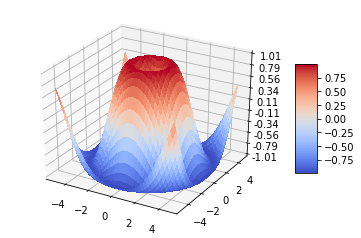

In [31]:
%matplotlib inline
'''
======================
3D surface (color map)
======================

Demonstrates plotting a 3D surface colored with the coolwarm color map.
The surface is made opaque by using antialiased=False.

Also demonstrates using the LinearLocator and custom formatting for the
z axis tick labels.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


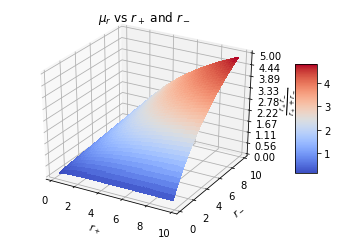

In [16]:
def get_reduced_rate(x,y):
    return x*y/(x+y)
fig = plt.figure()
ax = fig.gca(projection='3d')

forward_rate = np.arange(0.25,10, 0.25)
backward_rate = np.arange(0.25, 10, 0.25)
X,Y = np.meshgrid( forward_rate, backward_rate)
Z  = get_reduced_rate( X, Y )
surf = ax.plot_surface(X,Y,Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis
ax.set_zlim(0, 5)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title(r'$\mu_r$ vs $r_+$ and $r_-$')
ax.set_xlabel('$r_+$')
ax.set_ylabel('$r_-$')
ax.set_zlabel(r'$\frac{r_+r_-}{r_+ + r_-}$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)


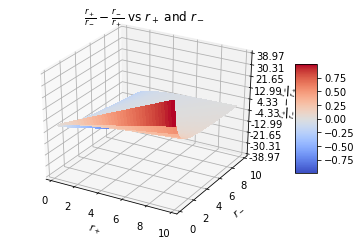

In [34]:
def get_net_likelihood(x,y):
    return x/y - y/x

def get_net_rate(x,y):
    return x - y
fig = plt.figure()
ax = fig.gca(projection='3d')

forward_rate = np.arange(0.25,10, 0.25)
backward_rate = np.arange(0.25, 10, 0.25)
X,Y = np.meshgrid( forward_rate, backward_rate)
Z  = get_net_likelihood( X, Y )
net_likelihood = ax.plot_surface(X,Y,Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

#Z2 = get_net_rate( X, Y)
#net_flux = ax.plot_surface(X,Y,Z2, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis
#ax.set_zlim(0, 5)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title(r'$\frac{r_+}{r_-} - \frac{r_-}{r_+}$ vs $r_+$ and $r_-$')
ax.set_xlabel('$r_+$')
ax.set_ylabel('$r_-$')
ax.set_zlabel(r'$\frac{r_+}{r_-} - \frac{r_-}{r_+}$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)


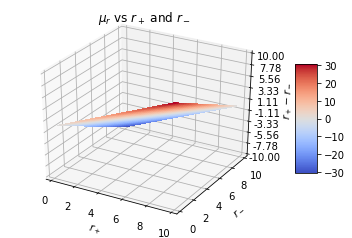

In [29]:
def get_net_likelihood(x,y):
    return x/y - y/x

def get_net_rate(x,y):
    return x - y
fig = plt.figure()
ax = fig.gca(projection='3d')

forward_rate = np.arange(0.25,10, 0.25)
backward_rate = np.arange(0.25, 10, 0.25)
X,Y = np.meshgrid( forward_rate, backward_rate)
Z  = get_net_likelihood( X, Y )
#net_likelihood = ax.plot_surface(X,Y,Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

Z2 = get_net_rate( X, Y)
net_flux = ax.plot_surface(X,Y,Z2, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis
ax.set_zlim(-10, 10)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title(r'$\mu_r$ vs $r_+$ and $r_-$')
ax.set_xlabel('$r_+$')
ax.set_ylabel('$r_-$')
ax.set_zlabel(r'$r_+ - r_-$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)


Text(0,0.5,'$r_+r_-/(r_+ + r_-)$')

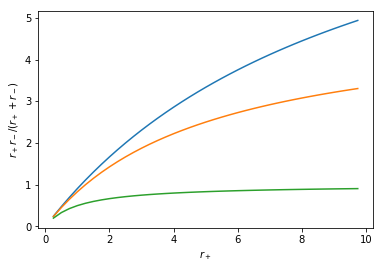

In [27]:
fig = plt.figure()
ax = fig.gca()

ax.plot(forward_rate, get_reduced_rate(forward_rate, 10))
ax.plot(forward_rate, get_reduced_rate(forward_rate, 5))
ax.plot(forward_rate, get_reduced_rate(forward_rate, 1))
ax.set_xlabel(r'$r_+$')
ax.set_ylabel(r'$r_+r_-/(r_+ + r_-)$')
